In [2]:
import pandas as pd

# CSV 파일 읽기
df_energy = pd.read_csv('한국남동발전_시간대별_풍력_발전실적_최종_진짜최종.csv')
df_energy.tail()

,발전구분,호기,일자,시간,발전량(kWh),설비용량(MW),연식(년)
102907,군위 화산풍력,1,2022-05-01,20,374.664714,1.65,1.9
102908,군위 화산풍력,1,2022-05-01,21,865.034571,1.65,1.9
102909,군위 화산풍력,1,2022-05-01,22,845.750429,1.65,1.9
102910,군위 화산풍력,1,2022-05-01,23,563.374429,1.65,1.9
102911,군위 화산풍력,1,2022-05-01,24,535.825571,1.65,1.9


### EDA

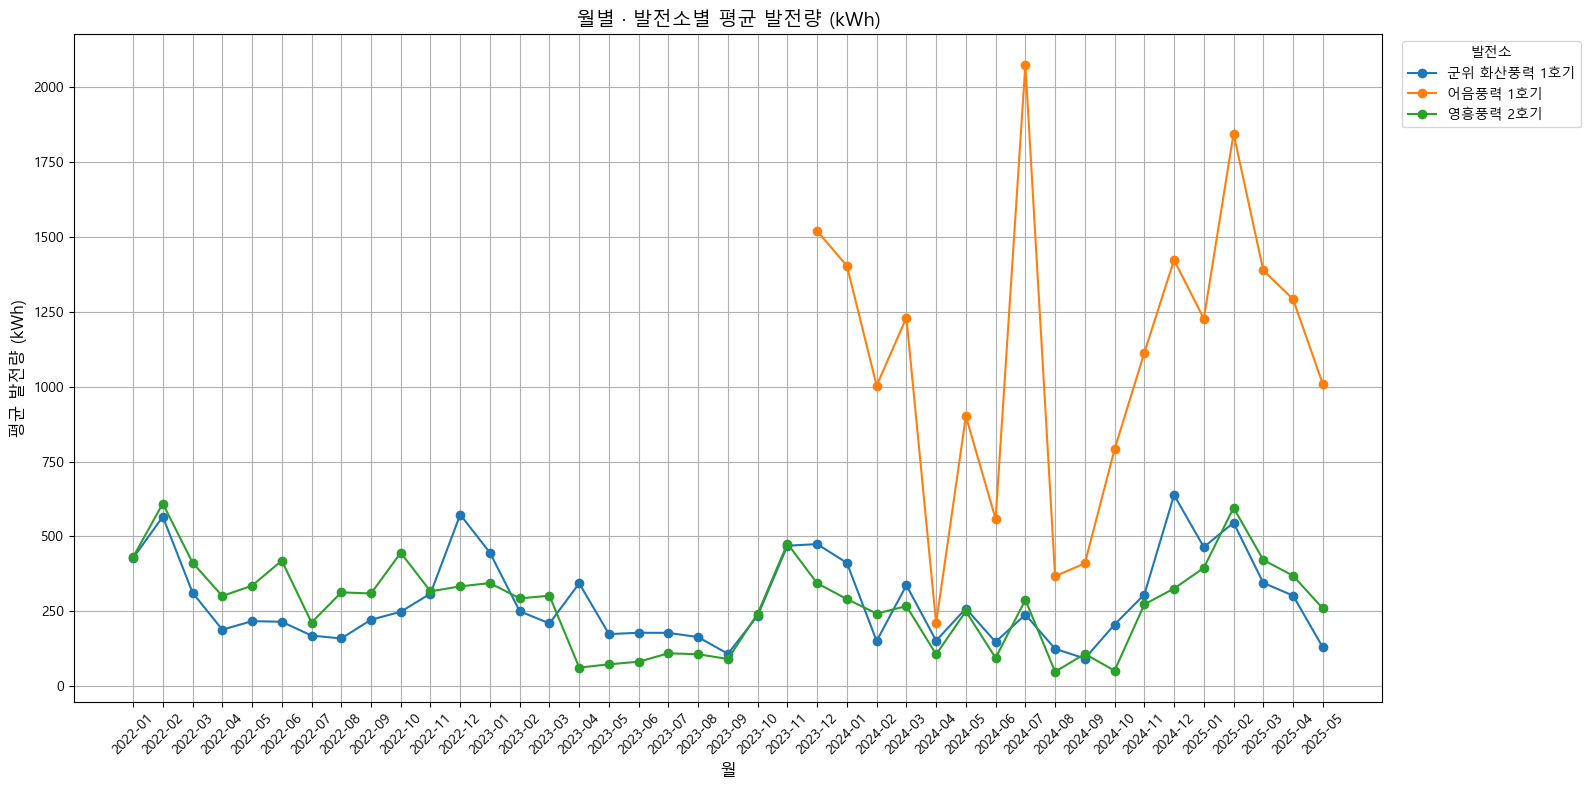

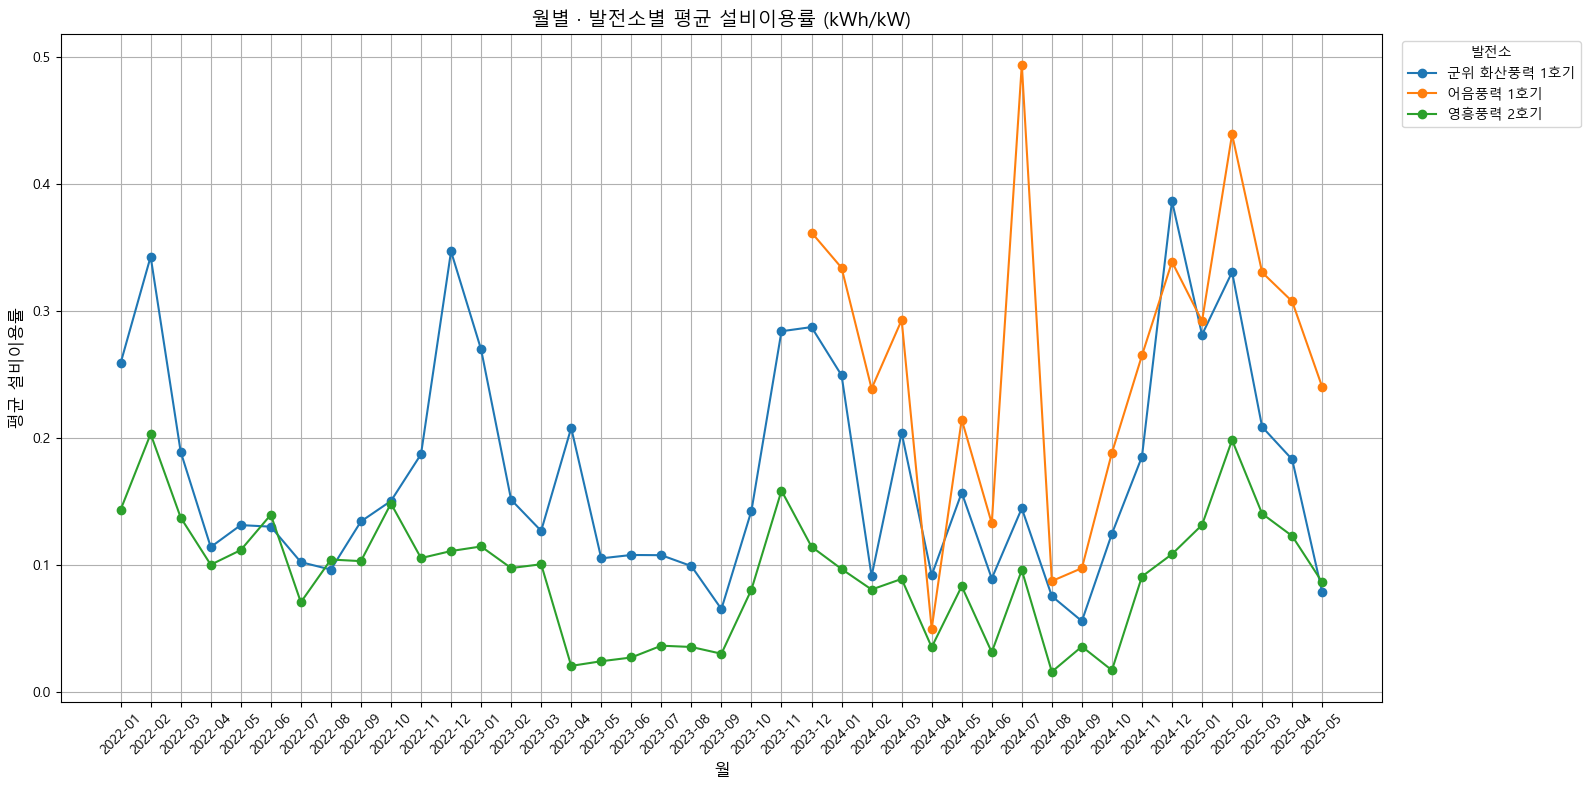

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import platform

# ✅ 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

# ✅ 1. CSV 파일 불러오기
file_path = '한국남동발전_시간대별_풍력_발전실적_최종_진짜최종.csv'
df = pd.read_csv(file_path, encoding='utf-8-sig')
# ✅ '삼천포풍력' 제외
df = df[df['발전구분'] != '삼천포풍력']


# ✅ 2. 날짜 변환 및 월 컬럼 생성
df['일자'] = pd.to_datetime(df['일자'])
df['월'] = df['일자'].dt.to_period('M')

# ✅ 3. 발전소 컬럼 생성
df['발전소'] = df['발전구분'].astype(str) + ' ' + df['호기'].astype(str) + '호기'

# ✅ 4. 발전량 기반 월별 평균
monthly_avg = df.groupby(['월', '발전소'])['발전량(kWh)'].mean().reset_index()

# ✅ 5. 설비이용률 계산 (kWh / (MW * 1000))
df['설비이용률'] = df['발전량(kWh)'] / (df['설비용량(MW)'] * 1000)
monthly_util = df.groupby(['월', '발전소'])['설비이용률'].mean().reset_index()

# ✅ 6. 그래프 1: 월별 · 발전소별 평균 발전량
plt.figure(figsize=(16, 8))
for name, group in monthly_avg.groupby('발전소'):
    plt.plot(group['월'].astype(str), group['발전량(kWh)'], marker='o', label=name)

plt.title('월별 · 발전소별 평균 발전량 (kWh)', fontsize=14)
plt.xlabel('월', fontsize=12)
plt.ylabel('평균 발전량 (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='발전소', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ✅ 7. 그래프 2: 월별 · 발전소별 평균 설비이용률
plt.figure(figsize=(16, 8))
for name, group in monthly_util.groupby('발전소'):
    plt.plot(group['월'].astype(str), group['설비이용률'], marker='o', label=name)

plt.title('월별 · 발전소별 평균 설비이용률 (kWh/kW)', fontsize=14)
plt.xlabel('월', fontsize=12)
plt.ylabel('평균 설비이용률', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='발전소', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [6]:
# ✅ 두 그래프를 하나의 이미지로 저장
fig, axes = plt.subplots(2, 1, figsize=(16, 14))

# ▶ 그래프 1: 발전량
for name, group in monthly_avg.groupby('발전소'):
    axes[0].plot(group['월'].astype(str), group['발전량(kWh)'], marker='o', label=name)

axes[0].set_title('월별 · 발전소별 평균 발전량 (kWh)', fontsize=14)
axes[0].set_xlabel('월', fontsize=12)
axes[0].set_ylabel('평균 발전량 (kWh)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)
axes[0].legend(title='발전소', bbox_to_anchor=(1.01, 1), loc='upper left')

# ▶ 그래프 2: 설비이용률
for name, group in monthly_util.groupby('발전소'):
    axes[1].plot(group['월'].astype(str), group['설비이용률'], marker='o', label=name)

axes[1].set_title('월별 · 발전소별 평균 설비이용률 (kWh/kW)', fontsize=14)
axes[1].set_xlabel('월', fontsize=12)
axes[1].set_ylabel('평균 설비이용률', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)
axes[1].legend(title='발전소', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.savefig('wind_발전량+설비이용률.png', dpi=300)
plt.close()


### 기상청 API 데이터 불러오기

In [5]:
import requests
import ssl
from requests.adapters import HTTPAdapter
from urllib3.poolmanager import PoolManager

class SSLAdapter(HTTPAdapter):
    def __init__(self, ssl_context=None, **kwargs):
        self.ssl_context = ssl_context
        super().__init__(**kwargs)

    def init_poolmanager(self, *args, **kwargs):
        kwargs['ssl_context'] = self.ssl_context
        return super().init_poolmanager(*args, **kwargs)

# TLS 1.2 이상의 context 강제 설정
context = ssl.create_default_context()
context.set_ciphers('DEFAULT@SECLEVEL=1')  # 낮은 보안 레벨 허용할 경우

session = requests.Session()
session.mount('https://', SSLAdapter(context))

# 요청 보내기
url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
params = {
    "serviceKey": "zJLFmDMckurk+au32kOHTxsrU5gG2NAadNE68xYaBW8PBJtdXN7F4QEpuW6f68GL0qLcMQsmgyPHxbOs43NCBA==",
    "numOfRows": "1000",
    "pageNo": "1",
    "dataType": "JSON",
    "base_date": "20250627",
    "base_time": "0500",
    "nx": "55",
    "ny": "127"
}
response = session.get(url, params=params)
print(response.json())


{'response': {'header': {'resultCode': '00', 'resultMsg': 'NORMAL_SERVICE'}, 'body': {'dataType': 'JSON', 'items': {'item': [{'baseDate': '20250627', 'baseTime': '0500', 'category': 'TMP', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '20', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'UUU', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '0.1', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'VVV', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '0.4', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'VEC', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '194', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'WSD', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '0.4', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'SKY', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '4', 

In [6]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# ----------------------------------------------------------------------
# 1. API 호출을 위한 기본 설정
# ----------------------------------------------------------------------

now = datetime.now()
if now.hour < 5:
    base_date = (now - timedelta(days=1)).strftime('%Y%m%d')
else:
    base_date = now.strftime('%Y%m%d')

url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
serviceKey = "zJLFmDMckurk+au32kOHTxsrU5gG2NAadNE68xYaBW8PBJtdXN7F4QEpuW6f68GL0qLcMQsmgyPHxbOs43NCBA=="  # 본인의 서비스 키로 변경하세요

# ----------------------------------------------------------------------
# 2. 반복문을 사용해 모든 페이지의 데이터 수집
# ----------------------------------------------------------------------

all_items = []
page_no = 1
num_of_rows = 5000

print("데이터 수집을 시작합니다...")

while True:
    print(f" - {page_no} 페이지 데이터 요청 중...")
    
    params = {
        'serviceKey': serviceKey,
        'numOfRows': str(num_of_rows),
        'pageNo': str(page_no),
        'dataType': 'JSON',
        'base_date': base_date,
        'base_time': '0500',
        'nx': '55',
        'ny': '127'
    }

    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()

        data = response.json()
        
        if data['response']['header']['resultCode'] != '00':
            print(f"❌ API 에러 응답: {data['response']['header']['resultMsg']}")
            break

        items = data['response']['body']['items'].get('item', [])
        all_items.extend(items)

        if len(items) < num_of_rows:
            print(f"마지막 페이지({page_no})입니다. 데이터 수집을 완료합니다.")
            break

        page_no += 1

    except requests.exceptions.RequestException as e:
        print(f"❌ 네트워크 또는 HTTP 에러 발생: {e}")
        break
    except requests.exceptions.JSONDecodeError:
        print("❌ JSON 파싱 에러: 서버 응답이 유효한 JSON이 아닙니다.")
        print(f"--- 서버 실제 응답 (Status: {response.status_code}) ---")
        print(response.text)
        break
    except KeyError:
        print("❌ 데이터 구조 에러: 응답 받은 JSON의 키가 예상과 다릅니다.")
        print("--- 서버 실제 응답 ---")
        print(data)
        break

# ----------------------------------------------------------------------
# 3. 수집된 모든 데이터를 표(DataFrame)로 변환 및 출력
# ----------------------------------------------------------------------

if all_items:
    df = pd.DataFrame(all_items)
    df.drop_duplicates(inplace=True)
    
    print(f"\n총 {len(df)}개의 유니크한 데이터를 수집했습니다. 표로 변환합니다.")

    # fcstDate와 fcstTime을 인덱스로 지정하여 pivot_table 생성
    pivot_df = df.pivot_table(
        index=['fcstDate', 'fcstTime'], 
        columns='category', 
        values='fcstValue', 
        aggfunc='first'
    ).reset_index()

    desired_order = ['fcstDate', 'fcstTime', 'TMP', 'SKY', 'PTY', 'POP', 'PCP', 'REH', 'WSD', 'SNO']
    current_columns = [col for col in desired_order if col in pivot_df.columns]
    remaining_columns = [col for col in pivot_df.columns if col not in current_columns]
    pivot_df = pivot_df[current_columns + remaining_columns]

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)

    print("\n--- 기상청 단기예보 (전체 데이터, 날짜 포함) ---")
    print(pivot_df)
else:
    print("\n수집된 데이터가 없습니다. 서비스 키 또는 요청 파라미터를 확인해주세요.")


데이터 수집을 시작합니다...
 - 1 페이지 데이터 요청 중...
마지막 페이지(1)입니다. 데이터 수집을 완료합니다.

총 907개의 유니크한 데이터를 수집했습니다. 표로 변환합니다.

--- 기상청 단기예보 (전체 데이터, 날짜 포함) ---
category  fcstDate fcstTime TMP SKY PTY POP     PCP  REH  WSD   SNO   TMN   TMX   UUU  VEC   VVV   WAV
0         20250627     0600  20   4   0  30    강수없음   95  0.4  적설없음   NaN   NaN   0.1  194   0.4  -999
1         20250627     0700  20   4   0  30    강수없음   90  0.8  적설없음   NaN   NaN   0.8  270     0  -999
2         20250627     0800  21   4   0  30    강수없음   90  0.8  적설없음   NaN   NaN  -0.2   23  -0.7  -999
3         20250627     0900  22   4   0  30    강수없음   85  1.5  적설없음   NaN   NaN  -0.3   16  -1.4  -999
4         20250627     1000  23   4   0  30    강수없음   85  2.4  적설없음   NaN   NaN  -1.9   57  -1.3  -999
5         20250627     1100  23   4   0  30    강수없음   85  2.9  적설없음   NaN   NaN  -2.4   59  -1.5  -999
6         20250627     1200  24   4   0  30    강수없음   85  3.4  적설없음   NaN   NaN  -2.8   58  -1.8  -999
7         20250627     1300  25   4  

In [7]:
pivot_df

category,fcstDate,fcstTime,TMP,SKY,PTY,POP,PCP,REH,WSD,SNO,TMN,TMX,UUU,VEC,VVV,WAV
0,20250627,0600,20,4,0,30,강수없음,95,0.4,적설없음,NaN,NaN,0.1,194,0.4,-999
1,20250627,0700,20,4,0,30,강수없음,90,0.8,적설없음,NaN,NaN,0.8,270,0,-999
2,20250627,0800,21,4,0,30,강수없음,90,0.8,적설없음,NaN,NaN,-0.2,23,-0.7,-999
3,20250627,0900,22,4,0,30,강수없음,85,1.5,적설없음,NaN,NaN,-0.3,16,-1.4,-999
4,20250627,1000,23,4,0,30,강수없음,85,2.4,적설없음,NaN,NaN,-1.9,57,-1.3,-999
5,20250627,1100,23,4,0,30,강수없음,85,2.9,적설없음,NaN,NaN,-2.4,59,-1.5,-999
6,20250627,1200,24,4,0,30,강수없음,85,3.4,적설없음,NaN,NaN,-2.8,58,-1.8,-999
7,20250627,1300,25,4,0,30,강수없음,80,2.3,적설없음,NaN,NaN,-2.1,70,-0.8,-999
8,20250627,1400,25,4,0,30,강수없음,80,3.3,적설없음,NaN,NaN,-3.2,83,-0.4,-999
9,20250627,1500,26,4,0,30,강수없음,80,2.9,적설없음,NaN,27.0,-2.8,86,-0.2,-999


<span style="font-size:12px">

## 🌦 기상청 예보 데이터 컬럼 설명

| 컬럼명 | 의미 | 단위 또는 값 |
|--------|------|---------------|
| `fcstDate` | 예보 날짜 | 예: `20250627` → 2025년 6월 27일 |
| `fcstTime` | 예보 시각 | 예: `0600` → 오전 6시 |
| `TMP` | 기온 | ℃ (섭씨 온도) |
| `SKY` | 하늘 상태 | 1: 맑음, 3: 구름 많음, 4: 흐림 |
| `PTY` | 강수 형태 | 0: 없음, 1: 비, 2: 비/눈, 3: 눈, 4: 소나기 등 |
| `POP` | 강수 확률 | % |
| `PCP` | 1시간 강수량 | mm 또는 `"강수없음"` |
| `REH` | 습도 | % |
| `WSD` | 풍속 | m/s (미터/초) |
| `SNO` | 1시간 적설량 | cm 또는 `"적설없음"` |
| `TMN` | 일 최저기온 | ℃ (해당 날짜 전체의 최저 예상 기온) |
| `TMX` | 일 최고기온 | ℃ (해당 날짜 전체의 최고 예상 기온) |
| `UUU` | 동서 바람 성분 | m/s (음수: 서풍, 양수: 동풍) |
| `VVV` | 남북 바람 성분 | m/s (음수: 북풍, 양수: 남풍) |
| `VEC` | 풍향 | 도 (°), 0: 북, 90: 동, 180: 남, 270: 서 |
| `WAV` | 파고 (해상용) | m (육상 예보에서는 -999로 무효 값 처리됨) |

---

## 💡 추가 설명

- `UUU`, `VVV`는 바람의 벡터 성분입니다.  
  → 풍속(`WSD`)과 풍향(`VEC`)으로부터 계산 가능  
  → `풍속^2 = UUU^2 + VVV^2`, `풍향 = atan2(UUU, VVV)`

- `TMX`, `TMN`은 하루에 한 번만 나타나며, 그 날 전체를 대표하는 예보입니다.

- `PCP`, `SNO`는 `"강수없음"`, `"적설없음"`처럼 문자열이 포함되어 있어 수치 분석 시 처리 필요합니다.

- `WAV`는 해양 예보 전용 항목이며, 육상에서는 대부분 `-999`로 나타나며 무시해도 무방합니다.


### 기상청 API 데이터 전처리

In [8]:
pivot_df.head(5)

category,fcstDate,fcstTime,TMP,SKY,PTY,POP,PCP,REH,WSD,SNO,TMN,TMX,UUU,VEC,VVV,WAV
0,20250627,0600,20,4,0,30,강수없음,95,0.4,적설없음,NaN,NaN,0.1,194,0.4,-999
1,20250627,0700,20,4,0,30,강수없음,90,0.8,적설없음,NaN,NaN,0.8,270,0,-999
2,20250627,0800,21,4,0,30,강수없음,90,0.8,적설없음,NaN,NaN,-0.2,23,-0.7,-999
3,20250627,0900,22,4,0,30,강수없음,85,1.5,적설없음,NaN,NaN,-0.3,16,-1.4,-999
4,20250627,1000,23,4,0,30,강수없음,85,2.4,적설없음,NaN,NaN,-1.9,57,-1.3,-999


In [9]:
# 제거할 컬럼 리스트
drop_columns = ['TMN', 'TMX', 'WAV', 'UUU', 'VVV', 'PTY', 'POP']

# 컬럼이 존재할 경우에만 삭제하도록 처리
pivot_df = pivot_df.drop(columns=[col for col in drop_columns if col in pivot_df.columns])


In [10]:
# 컬럼명 매핑 딕셔너리 (SKY 추가됨)
rename_dict = {
    'fcstDate': '일자',
    'fcstTime': '시간',
    'TMP': '기온(°C)',
    'PCP': '강수량(mm)',
    'REH': '습도(%)',
    'WSD': '풍속(m/s)',
    'SNO': '적설(cm)',
    'VEC': '풍향(16방위)',
    'SKY': '하늘상태',
}

# 컬럼명 변경
pivot_df = pivot_df.rename(columns=rename_dict)



In [11]:
# 일자 변환 ('YYYYMMDD' 형식인 경우에만 변환)
if pivot_df['일자'].dtype == object and pivot_df['일자'].str.match(r'^\d{8}$').all():
    pivot_df['일자'] = pd.to_datetime(pivot_df['일자'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

# 시간 변환 ('HHMM' 문자열 형식인 경우에만 변환)
if pivot_df['시간'].dtype == object and pivot_df['시간'].str.match(r'^\d{4}$').all():
    pivot_df['시간'] = pivot_df['시간'].astype(str).str[:2].astype(int)


In [12]:
import re

def clean_precip(val):
    # NaN이면 그대로 반환
    if pd.isna(val):
        return val
    val = str(val)
    
    # 강수없음, 적설없음 → 0
    if '없음' in val:
        return 0.0
    
    # 1mm 미만 → 관례적으로 0.5로 처리하거나 0.0으로 처리 가능
    if '미만' in val:
        return 0.5  # 또는 0.0으로 바꿔도 됨
    
    # 숫자만 추출 (예: '2.5mm' → 2.5)
    numeric_part = re.findall(r"[\d.]+", val)
    return float(numeric_part[0]) if numeric_part else 0.0

# 적용
pivot_df['강수량(mm)'] = pivot_df['강수량(mm)'].apply(clean_precip)
pivot_df['적설(cm)'] = pivot_df['적설(cm)'].apply(clean_precip)


In [13]:
pivot_df.head(5)

category,일자,시간,기온(°C),하늘상태,강수량(mm),습도(%),풍속(m/s),적설(cm),풍향(16방위)
0,2025-06-27,6,20,4,0.0,95,0.4,0.0,194
1,2025-06-27,7,20,4,0.0,90,0.8,0.0,270
2,2025-06-27,8,21,4,0.0,90,0.8,0.0,23
3,2025-06-27,9,22,4,0.0,85,1.5,0.0,16
4,2025-06-27,10,23,4,0.0,85,2.4,0.0,57


### 기상청 csv 데이터 전처리

In [7]:
df_weather = pd.read_csv('weather_merged_final.csv')

df_weather.head(5)

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일사(MJ/m2),적설(cm),전운량(10분위)
0,90,속초,2022-01-01 01:00,-7.7,NaN,1.5,270.0,32.0,1026.6,NaN,22.1,1.0
1,90,속초,2022-01-01 02:00,-8.0,NaN,1.9,270.0,32.0,1027.2,NaN,22.1,1.0
2,90,속초,2022-01-01 03:00,-8.3,NaN,1.3,270.0,34.0,1027.8,NaN,22.1,1.0
3,90,속초,2022-01-01 04:00,-8.2,NaN,1.5,270.0,33.0,1027.4,NaN,22.1,2.0
4,90,속초,2022-01-01 05:00,-8.1,NaN,1.6,270.0,32.0,1026.9,NaN,22.1,1.0


In [8]:
# 제거할 컬럼 리스트
drop_columns = ['지점', '현지기압(hPa)', '일사(MJ/m2)']

# 컬럼이 존재할 경우에만 삭제하도록 처리
df_weather = df_weather.drop(columns=[col for col in drop_columns if col in df_weather.columns])
df_weather.head(5)

,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),적설(cm),전운량(10분위)
0,속초,2022-01-01 01:00,-7.7,NaN,1.5,270.0,32.0,22.1,1.0
1,속초,2022-01-01 02:00,-8.0,NaN,1.9,270.0,32.0,22.1,1.0
2,속초,2022-01-01 03:00,-8.3,NaN,1.3,270.0,34.0,22.1,1.0
3,속초,2022-01-01 04:00,-8.2,NaN,1.5,270.0,33.0,22.1,2.0
4,속초,2022-01-01 05:00,-8.1,NaN,1.6,270.0,32.0,22.1,1.0


In [9]:
# datetime 형식으로 변환
df_weather['일시'] = pd.to_datetime(df_weather['일시'])

# 일자, 시간 컬럼 생성
df_weather['일자'] = df_weather['일시'].dt.strftime('%Y-%m-%d')
df_weather['시간'] = df_weather['일시'].dt.hour

# 조건: 시간이 0이면
mask = df_weather['시간'] == 0

# 시간 0을 24로 바꾸고, 일자는 하루 전으로 변경
df_weather.loc[mask, '시간'] = 24
df_weather.loc[mask, '일자'] = (df_weather.loc[mask, '일시'] - pd.Timedelta(days=1)).dt.strftime('%Y-%m-%d')

# 기존 '일시' 컬럼 삭제
df_weather = df_weather.drop(columns=['일시'])

# 확인
df_weather.head(5)


,지점명,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),적설(cm),전운량(10분위),일자,시간
0,속초,-7.7,NaN,1.5,270.0,32.0,22.1,1.0,2022-01-01,1
1,속초,-8.0,NaN,1.9,270.0,32.0,22.1,1.0,2022-01-01,2
2,속초,-8.3,NaN,1.3,270.0,34.0,22.1,1.0,2022-01-01,3
3,속초,-8.2,NaN,1.5,270.0,33.0,22.1,2.0,2022-01-01,4
4,속초,-8.1,NaN,1.6,270.0,32.0,22.1,1.0,2022-01-01,5


In [10]:
# 현재 컬럼들 확인
cols = df_weather.columns.tolist()

# 기준이 되는 컬럼 이름 (예: '지점' 또는 '지점명')
key_col = '지점명'  # 또는 '지점'으로 바꿔도 됨

# '지점명' 다음에 '일자', '시간'을 삽입
if key_col in cols:
    idx = cols.index(key_col)
    # 기존에 '일자', '시간'이 이미 들어있다면 먼저 제거
    for c in ['일자', '시간']:
        if c in cols:
            cols.remove(c)
    # 삽입
    new_order = cols[:idx+1] + ['일자', '시간'] + cols[idx+1:]
    df_weather = df_weather[new_order]
else:
    print(f"⚠️ 컬럼 '{key_col}'이 존재하지 않습니다.")

df_weather.head(5)

,지점명,일자,시간,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),적설(cm),전운량(10분위)
0,속초,2022-01-01,1,-7.7,NaN,1.5,270.0,32.0,22.1,1.0
1,속초,2022-01-01,2,-8.0,NaN,1.9,270.0,32.0,22.1,1.0
2,속초,2022-01-01,3,-8.3,NaN,1.3,270.0,34.0,22.1,1.0
3,속초,2022-01-01,4,-8.2,NaN,1.5,270.0,33.0,22.1,2.0
4,속초,2022-01-01,5,-8.1,NaN,1.6,270.0,32.0,22.1,1.0


In [11]:
def map_cloud_to_sky(cloud):
    if pd.isna(cloud):
        return None
    try:
        c = float(cloud)
    except:
        return None
    if c <= 2:
        return 1
    elif c <= 7:
        return 3
    else:
        return 4
    
df_weather = df_weather.rename(columns={'전운량(10분위)': '하늘상태'})

# 전운량 컬럼이 '전운량(10분위)'라는 이름일 경우
df_weather['하늘상태'] = df_weather['하늘상태'].apply(map_cloud_to_sky)


df_weather.head(5)

,지점명,일자,시간,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),적설(cm),하늘상태
0,속초,2022-01-01,1,-7.7,NaN,1.5,270.0,32.0,22.1,1.0
1,속초,2022-01-01,2,-8.0,NaN,1.9,270.0,32.0,22.1,1.0
2,속초,2022-01-01,3,-8.3,NaN,1.3,270.0,34.0,22.1,1.0
3,속초,2022-01-01,4,-8.2,NaN,1.5,270.0,33.0,22.1,1.0
4,속초,2022-01-01,5,-8.1,NaN,1.6,270.0,32.0,22.1,1.0


In [12]:
df_weather['강수량(mm)'] = df_weather['강수량(mm)'].fillna(0)
df_weather['적설(cm)'] = df_weather['적설(cm)'].fillna(0)


### 발전량 데이터 + 기상청 데이터

In [13]:
# 3. 발전소 → 지점명 매핑
plant_to_location = {
    '삼천포풍력': '통영',
    '영흥풍력': '인천',
    '군위 화산풍력': '영천',
    '어음풍력': '제주'
}

# 4. 지점명 컬럼 추가
df_energy['지점명'] = df_energy['발전구분'].map(plant_to_location)

df_energy['지점명'] = df_energy['지점명'].astype(str).str.strip()
df_weather['지점명'] = df_weather['지점명'].astype(str).str.strip()

# 5. 날짜 형식 맞추기 (둘 다 'YYYY-MM-DD' 형태여야 병합됨)
df_energy['일자'] = pd.to_datetime(df_energy['일자']).dt.strftime('%Y-%m-%d')
df_weather['일자'] = pd.to_datetime(df_weather['일자']).dt.strftime('%Y-%m-%d')

df_energy['시간'] = df_energy['시간'].astype(int)
df_weather['시간'] = df_weather['시간'].astype(int)

# 6. 병합: 지점명 + 일자 + 시간 기준
df_merged = pd.merge(df_energy, df_weather, on=['지점명', '일자', '시간'], how='left')

# 7. 결과 확인
print(df_merged.tail())

df_merged = df_merged[df_merged['발전구분'] != '삼천포풍력']


           발전구분  호기          일자  시간    발전량(kWh)  설비용량(MW)  연식(년) 지점명  기온(°C)  \
102907  군위 화산풍력   1  2022-05-01  20  374.664714      1.65    1.9  영천    15.0   
102908  군위 화산풍력   1  2022-05-01  21  865.034571      1.65    1.9  영천    14.0   
102909  군위 화산풍력   1  2022-05-01  22  845.750429      1.65    1.9  영천    12.0   
102910  군위 화산풍력   1  2022-05-01  23  563.374429      1.65    1.9  영천    11.1   
102911  군위 화산풍력   1  2022-05-01  24  535.825571      1.65    1.9  영천     7.8   

        강수량(mm)  풍속(m/s)  풍향(16방위)  습도(%)  적설(cm)  하늘상태  
102907      0.0      1.8     290.0   35.0     0.0   1.0  
102908      0.0      2.6     290.0   37.0     0.0   1.0  
102909      0.0      1.7     290.0   42.0     0.0   1.0  
102910      0.0      1.5     290.0   42.0     0.0   1.0  
102911      0.0      0.5      70.0   67.0     0.0   1.0  


In [15]:
import pandas as pd
import pvlib

# 1) 위도·경도 정보 (지점 기준)
location_info = {
    '영흥풍력': (37.1508, 126.4506),
    '군위 화산풍력': (36.2745, 128.3720),
    '어음풍력': (33.4584, 126.4480),
}

# 2) 시간 형변환 및 24시 처리
df_merged['시간'] = df_merged['시간'].astype(int)
df_merged['시간조정'] = df_merged['시간'] % 24
df_merged['일자조정'] = pd.to_datetime(df_merged['일자']) + pd.to_timedelta((df_merged['시간'] // 24), unit='D')

# 3) '일시' 컬럼 생성 + 타임존 지정 (Asia/Seoul)
df_merged['일시'] = pd.to_datetime(
    df_merged['일자조정'].dt.strftime('%Y-%m-%d') + ' ' + df_merged['시간조정'].astype(str) + ':00:00'
)
df_merged['일시'] = df_merged['일시'].dt.tz_localize('Asia/Seoul')  # 핵심 수정!

# 4) 태양 위치 계산 함수
def compute_solar_pos(row):
    plant = row['발전구분']
    dt = row['일시']
    if plant not in location_info:
        return pd.Series([None, None])
    lat, lon = location_info[plant]
    loc = pvlib.location.Location(lat, lon, tz='Asia/Seoul')
    pos = loc.get_solarposition(times=[dt])
    return pd.Series([pos['apparent_elevation'].iloc[0], pos['azimuth'].iloc[0]])

# 5) 계산 적용
df_merged[['태양고도', '방위각']] = df_merged.apply(compute_solar_pos, axis=1)

# 6) 고도가 0 이하인 경우 방위각 결측 처리
df_merged.loc[df_merged['태양고도'] <= 0, '방위각'] = None

# 7) 시간대별 평균 고도 계산 (정상 확인용)
summary_hour = df_merged.groupby(df_merged['일시'].dt.hour)['태양고도'].mean().reset_index()
summary_hour.columns = ['시간대', '평균 고도 (°)']
print(summary_hour)

# 원한다면 저장도 가능
# summary_hour.to_csv('평균_고도_시간대별.csv', index=False)


KeyboardInterrupt: 

In [32]:
import numpy as np

df_merged.loc[df_merged['태양고도'] < 0, '태양고도'] = 0
df_merged.loc[df_merged['태양고도'] <= 0, '방위각'] = np.nan


In [37]:
df_merged = df_merged.drop(columns=[
    '시간조정', '일자조정', '일시', 'sun_elevation', 'sun_azimuth', 'hour'
], errors='ignore')


In [38]:
df_merged.to_csv('df_merged_wind_final.csv', index=False, encoding='utf-8-sig')

### 통합 데이터셋 EDA

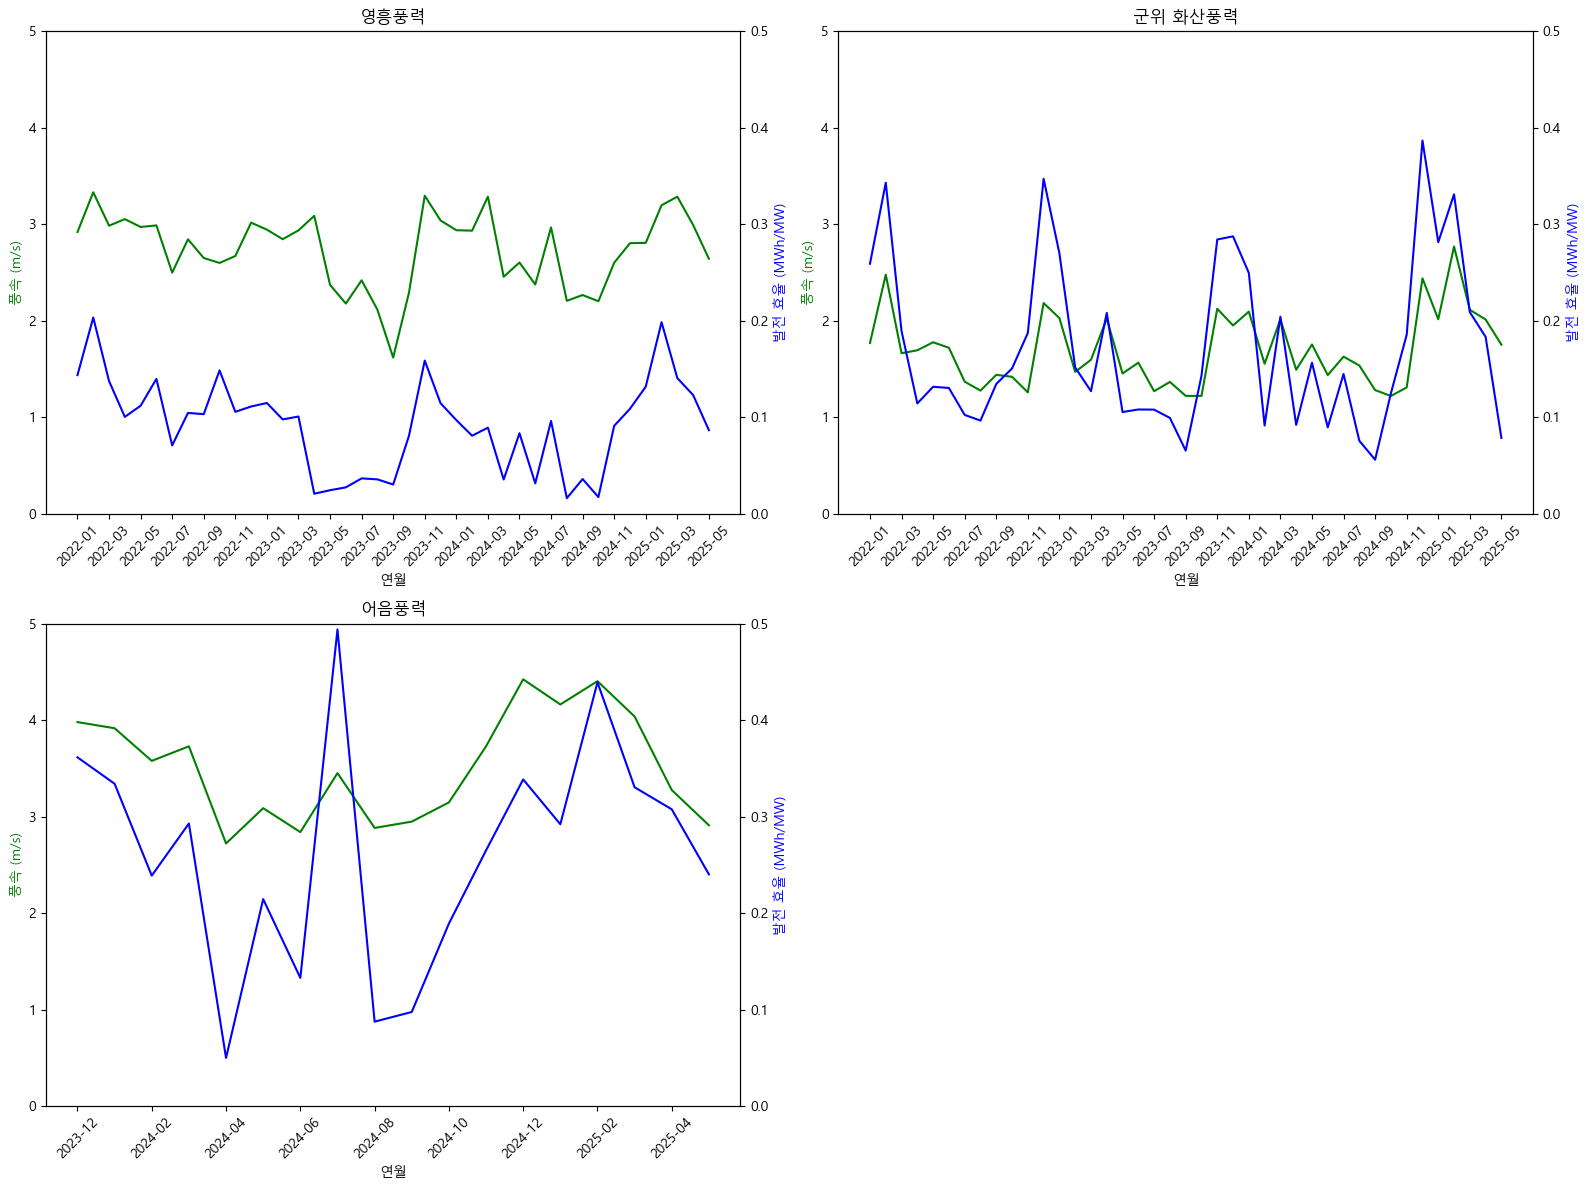

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

import math

# 발전소 목록
plants = df_merged['발전구분'].unique()
cols = 2
rows = math.ceil(len(plants) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
axes = axes.flatten()

# 1. 연월 처리
df_merged['일자'] = pd.to_datetime(df_merged['일자'], errors='coerce')
df_merged['연월'] = df_merged['일자'].dt.to_period('M').astype(str)
df_merged['효율'] = df_merged['발전량(kWh)'] / df_merged['설비용량(MW)'] / 1000  # ⚠️ 1000으로 나눔
df_merged = df_merged.dropna(subset=['효율', '풍속(m/s)', '연월', '발전구분'])

# 고정된 y축 범위 설정
풍속_min, 풍속_max = 0, 5
효율_min, 효율_max = 0, 0.5  # ⚠️ 효율 y축도 0~5로 조정

# 발전소 목록
plants = df_merged['발전구분'].unique()

for i, plant in enumerate(plants):
    sub = df_merged[df_merged['발전구분'] == plant]
    if sub.empty:
        continue

    monthly = sub.groupby('연월')[['풍속(m/s)', '효율']].mean().reset_index()
    monthly['연월'] = pd.to_datetime(monthly['연월'])
    monthly = monthly.sort_values('연월').reset_index(drop=True)

    ax1 = axes[i]
    ax2 = ax1.twinx()

    ax1.plot(monthly.index, monthly['풍속(m/s)'], 'g-')
    ax2.plot(monthly.index, monthly['효율'], 'b-')

    tick_interval = 2
    ticks = list(range(0, len(monthly), tick_interval))
    tick_labels = monthly['연월'].dt.strftime('%Y-%m')[ticks]
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(tick_labels, rotation=45)

    ax1.set_xlabel('연월')
    ax1.set_ylabel('풍속 (m/s)', color='g')
    ax2.set_ylabel('발전 효율 (MWh/MW)', color='b')

    ax1.set_ylim(풍속_min, 풍속_max)
    ax2.set_ylim(효율_min, 효율_max)
    ax1.set_title(f'{plant}')

# 남는 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('wind_풍속-발전효율_ALL.png', dpi=300)
plt.show()

